In [1]:
from bospy import bos

In [2]:
fcu_pts = bos.QueryPoints(parent_types="brick:Fan_Coil_Unit")
for p in fcu_pts:
    name = bos.GetName(p)
    print(f"{name}\t = \'{p}\'")

zone_temp	 = 'bos://localhost/dev/12/pts/1'
solar_irradiance	 = 'bos://localhost/dev/12/pts/10'
wind_speed	 = 'bos://localhost/dev/12/pts/11'
cooling_override	 = 'bos://localhost/dev/12/pts/12'
heating_override	 = 'bos://localhost/dev/12/pts/13'
fan_override	 = 'bos://localhost/dev/12/pts/14'
flow_setpoint	 = 'bos://localhost/dev/12/pts/15'
supply_temp_override	 = 'bos://localhost/dev/12/pts/16'
zone_clg_stpt	 = 'bos://localhost/dev/12/pts/2'
zone_htg_stpt	 = 'bos://localhost/dev/12/pts/3'
sa_temp_stpt	 = 'bos://localhost/dev/12/pts/4'
oa_temp	 = 'bos://localhost/dev/12/pts/5'
air_flow	 = 'bos://localhost/dev/12/pts/6'
cooling_power	 = 'bos://localhost/dev/12/pts/7'
heating_power	 = 'bos://localhost/dev/12/pts/8'
fan_power	 = 'bos://localhost/dev/12/pts/9'


In [3]:
oa = 'bos://localhost/dev/12/pts/5'
sa = 'bos://localhost/dev/12/pts/4'
za = 'bos://localhost/dev/12/pts/1'
stpt = 'bos://localhost/dev/12/pts/3'
solar = 'bos://localhost/dev/12/pts/10'
fan = 'bos://localhost/dev/12/pts/6'

In [19]:
pts = [oa, sa, za, stpt, solar, fan]
df = bos.GetHistory(pts,
               start='2025/1/1T00:00:00-06',
               end='2025/1/30T24:00:00-06',
               pandas=True, tz='America/Denver', get_names=True).reset_index()
df.head()

,time,zone_temp,solar_irradiance,zone_htg_stpt,sa_temp_stpt,oa_temp,air_flow
0,2025-01-05 23:00:00-07:00,290.036865,0.0,288.149994,294.149994,269.850006,0.0
1,2025-01-05 23:15:00-07:00,289.873779,0.0,288.149994,294.149994,269.696350,0.0
2,2025-01-05 23:30:00-07:00,289.716217,0.0,288.149994,294.149994,269.621765,0.0
3,2025-01-05 23:45:00-07:00,289.567017,0.0,288.149994,294.149994,269.661285,0.0
4,2025-01-06 00:00:00-07:00,289.430450,0.0,288.149994,294.149994,269.850006,0.0


In [86]:
import pandas as pd
import numpy as np

# predictions for the next time step, t+1
y = df['zone_temp'].iloc[1:].copy()
print(y.shape)

# feature vector for the current time, t
X = df.iloc[:-1].copy()
X['timestamp'] = pd.to_datetime(X['time'])

# Extract time features
X['day_of_week'] = X['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
X['hour_of_day'] = X['timestamp'].dt.hour       # 0-23
X['minute_of_day'] = X['timestamp'].dt.hour * 60 + X['timestamp'].dt.minute
X = X.drop('time', axis=1)
X = X.drop('timestamp', axis=1)
X = X.astype(np.float32)
X

(2585,)


,zone_temp,solar_irradiance,zone_htg_stpt,sa_temp_stpt,oa_temp,air_flow,day_of_week,hour_of_day,minute_of_day
0,290.036865,0.0,288.149994,294.149994,269.850006,0.0,6.0,23.0,1380.0
1,289.873779,0.0,288.149994,294.149994,269.696350,0.0,6.0,23.0,1395.0
2,289.716217,0.0,288.149994,294.149994,269.621765,0.0,6.0,23.0,1410.0
3,289.567017,0.0,288.149994,294.149994,269.661285,0.0,6.0,23.0,1425.0
4,289.430450,0.0,288.149994,294.149994,269.850006,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2580,291.233887,0.0,288.149994,294.149994,267.549988,0.0,3.0,21.0,1305.0
2581,291.094452,0.0,288.149994,294.149994,267.549988,0.0,3.0,22.0,1320.0
2582,290.947205,0.0,288.149994,294.149994,267.549988,0.0,3.0,22.0,1335.0
2583,290.791809,0.0,288.149994,294.149994,267.549988,0.0,3.0,22.0,1350.0


In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [114]:
model.coef_

array([ 9.6503073e-01,  4.4030344e-04, -5.5299941e-03,  7.6706768e-03,
        6.0946206e-03, -4.7564404e-03,  6.0852389e-03,  2.0506859e-01,
       -3.4438954e-03], dtype=float32)

In [91]:
y_pred = model.predict(X_test)

In [92]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2:.5f}")
print(f"Mean Squared Error: {mse:.2f}")

R-squared: 0.96389
Mean Squared Error: 0.41


In [93]:
import matplotlib.pyplot as plt

In [94]:
print(model.coef_)

[ 9.6503073e-01  4.4030344e-04 -5.5299941e-03  7.6706768e-03
  6.0946206e-03 -4.7564404e-03  6.0852389e-03  2.0506859e-01
 -3.4438954e-03]


# write to redis

In [129]:
from bospy import run

{'FLOW_ID': 0, 'NODE_ID': 0, 'TXN_ID': 0, 'WRITE_TOKEN': '000000000000', 'READ_TOKEN': '000000000000'}


In [130]:
import json
print(model.coef_)
json_string = json.dumps(model.coef_.tolist())
print(json_string)
run.Return(json_string)

[ 9.6503073e-01  4.4030344e-04 -5.5299941e-03  7.6706768e-03
  6.0946206e-03 -4.7564404e-03  6.0852389e-03  2.0506859e-01
 -3.4438954e-03]
[0.9650307297706604, 0.0004403034399729222, -0.005529994145035744, 0.007670676801353693, 0.0060946205630898476, -0.004756440408527851, 0.0060852388851344585, 0.20506858825683594, -0.003443895373493433]


AttributeError: module 'bospy.common_pb2_grpc' has no attribute 'ScheduleStub'

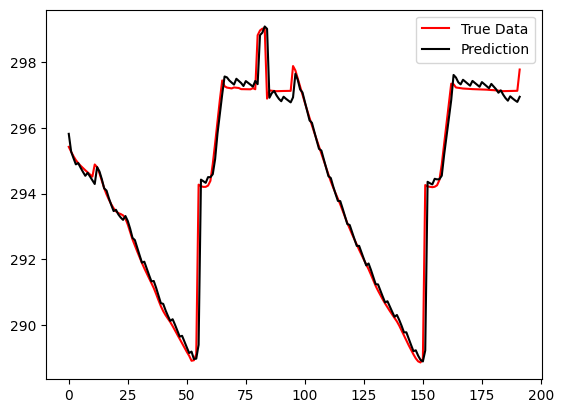

In [119]:
import matplotlib.pyplot as plt

steps_per_day = 96
start, end = steps_per_day * 2, steps_per_day * 4
sample_nums = [x for x in range(y[start:end].shape[0])]

plt.plot(sample_nums, y[start:end], color='red', label='True Data')
plt.plot(sample_nums, model.predict(X[start:end]), color='black', label='Prediction')
plt.legend()
plt.show()
# plt.plot(Y)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
class SimpleRegressionNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleRegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64) # First fully connected layer
        self.relu = nn.ReLU()                # Activation function
        self.fc2 = nn.Linear(64, 1)          # Output layer for a single prediction

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
input_size = num_features
model = SimpleRegressionNet(input_size)
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
X = torch.tensor(X.to_numpy())
y = torch.tensor(y.to_numpy())

In [ ]:
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward and optimize
    optimizer.zero_grad() # Clear previous gradients
    loss.backward()       # Compute gradients
    optimizer.step()      # Update model parameters

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Example: New feature vector for prediction
new_feature_vector = torch.randn(1, num_features)
model.eval() # Set model to evaluation mode (disables dropout, batch norm updates, etc.)
with torch.no_grad(): # Disable gradient calculations for inference
    predicted_value = model(new_feature_vector)
print(f"Predicted value for new feature vector: {predicted_value.item():.4f}")